In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.nn import fractional_max_pool
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Add, Dense, Convolution2D, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Layer, Activation, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import pickle
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random
import os
from google.colab.patches import cv2_imshow
import cv2 as cv

%matplotlib inline 

#Split data

In [0]:
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split 
from PIL import Image
import pandas as pd
import numpy as np


DATA_PATH = "/content/drive/My Drive/data/"
val_test_percent = .2

#предсказываемые классы
classes = ['upper-body', 'lower-body',  'full-body']

#выделяем из общего дата сета по 1100 картинок на класс структура 'image_name','x1', 'y1', 'x2', 'y2','category_type'
def split_dataset(num = 1100):  
  def annotate_df_create(path,num):
    img_cats = pd.read_csv(path+'Anno/list_category_img.csv')

    cloth_cats = pd.read_csv(path+'Anno/list_category_cloth.csv')
    cloth_cats['category_label'] = cloth_cats.index+1
    bbox = pd.read_csv(path+'Anno/list_bbox.csv')

    df = img_cats.merge(cloth_cats, left_on='category_label', right_on='category_label').merge(bbox, left_on='image_name', right_on='image_name')
    df = df[(df.x1>0) & (df.x2<300) & (df.x2-df.x1<150)]
    #df = df[df.x1>0 & df.x2<300 & df.x2-df.x1<150]

    #df = df.groupby('category_type').head()
    df = df.groupby('category_type').apply(lambda x: x.sample(num)).reset_index(drop=True)


    #df.image_name = 'C:/Users/r.bukin/R/DeepFashion/DeepFashion-master/fashion_data/'+df.image_name
    df.image_name = path+df.image_name #'/content/drive/My Drive/data/'+df.image_name
    #df.image_name = "/content/drive/'My Drive'/data/"+df.image_name

    #df.loc[:,('image_name','x1', 'y1', 'x2', 'y2','category_type')].to_csv('annotate.txt', header  = False, index = False)

    #df['label'] = pd.Series(df.loc[:,('x1', 'y1', 'x2', 'y2','category_type')].values.tolist()).map(lambda x: ','.join(map(str,x)))

    #class id must be less than num_classes
    df['category_type'] = df['category_type']-1
    return df.loc[:,('image_name','x1', 'y1', 'x2', 'y2','category_type')]  
    #return df.loc[:,('image_name','label')]   
    
  df = annotate_df_create(DATA_PATH,num)
  
  labels = df.category_type
  train_X, test_X, train_Y, test_Y = train_test_split(df, labels, test_size=val_test_percent, random_state=42)
  val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size=.5, random_state=42)

  return (train_X, train_Y, val_X, val_Y, test_X, test_Y) 
  
  
  #train_df, test_df = train_test_split(df, test_size=test_percent, random_state=42)
  #train_df, val_df = train_test_split(train_df, test_size=val_percent, random_state=42)
  
  #return (train_df,val_df,test_df)
  

#   raw = np.array(list(map(lambda x: bounding_box(x), df.image_name)))
#   labels = df.category_type
#   train_X, test_X, train_Y, test_Y = train_test_split(raw, labels, test_size=val_test_percent, random_state=42)
#   val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size=.5, random_state=42)
  
#   return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

#разбиваем на выборки 
train_X, train_Y, val_X, val_Y, test_X, test_Y = split_dataset()
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, val_X.shape, val_Y.shape)



(2640, 6) (2640,) (330, 6) (330,) (330, 6) (330,)


In [0]:
#директории для генераторов
!mkdir train
!mkdir train/upper-body
!mkdir train/lower-body
!mkdir train/full-body
!mkdir test
!mkdir test/upper-body
!mkdir test/lower-body
!mkdir test/full-body
!mkdir val
!mkdir val/upper-body
!mkdir val/lower-body
!mkdir val/full-body

#base model with bounding_box

In [0]:
#вырезаем боксы из катринок созраняем в деректории для генератора
import os 
import cv2 as cv

def bounding_box(src,dst,x1,y1,x2,y2):
  im = cv.imread(src)  
  cv.imwrite(dst,im[y1:y2, x1:x2])
  

def prepare_df(dir_name,X,Y):  
  for x,y in zip(X.iterrows(),Y):    
    src = x[1]['image_name']
    path,fn = os.path.split(src)
    dst = os.path.join(dir_name,classes[y],os.path.split(path)[1]+fn)
    bounding_box(src,dst,x[1]['x1'],x[1]['y1'],x[1]['x2'],x[1]['y2'])


prepare_df('train',train_X,train_Y)  
prepare_df('test',test_X,test_Y)  
prepare_df('val',val_X,val_Y) 
# def bounding_box(x):
#   print(x)
# val_X.applymap(lambda x: bounding_box(x))

In [0]:
!ls val/full-body

In [0]:
from google.colab.patches import cv2_imshow

src = 'val/full-body/Plunging_V-Neckline_Dressimg_00000037.jpg' #val_X.image_name.iloc[0]
im = cv.imread(src)
cv2_imshow(im) 

In [0]:
def create_model(params):
  model = Sequential()
  # first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # softmax classifier
  model.add(Dense(nb_classes))
  model.add(Activation("softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

  # return the constructed network architecture
  return model  

def create_model1(params,comp=True): 
  X_input = Input(input_shape)  
  
  #1 слой свертки
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(X_input)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  x_shortcut = x 
  
  #2 слой свертки
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)  
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 3*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)

  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)

  x_shortcut = x 
  #3 слой свертки
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 4*params['filters'], kernel_size = (1,1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)
  
  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)
  
  #выходной слой
  x = AveragePooling2D((2,2), name="avg_pool")(x)
  x = Dropout(params['drop'])(x)    
  x = Flatten()(x)  
  #x = GlobalAveragePooling2D()(x)
    
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dropout(params['drop'])(x)
  x = Dense(nb_classes, activation='softmax')(x)
  model = Model(inputs = X_input, outputs = x)  
  
  if comp==True:
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
  return(model)  

def callbacks():
  def step_decay(epoch):
    initial_lrate = 1e-1
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate    

  lrate = LearningRateScheduler (step_decay)  

  сheckpoint = ModelCheckpoint('model.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)
  
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                              patience=3, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  
  earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10,verbose=0, mode='auto')
  
  return [сheckpoint,lrate,earlystop]

In [0]:
input_shape = (56,56,3)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=input_shape[:-1],
        batch_size=32)

val_generator = val_datagen.flow_from_directory(
        'val',
        target_size=input_shape[:-1],
        batch_size=32)

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=input_shape[:-1],
        batch_size=32)

Found 2640 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [0]:
# Размер мини-выборки
batch_size = 128
# Количество классов изображений
nb_classes = 3
# Названия классов 
classes=['upper-body', 'lower-body',  'full-body']

In [0]:

input_shape = (56,56,3)
weight_decay = 1e-4
params = {'activation': 'elu', 'batch_size': 32, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32}
batch_size = params['batch_size']

model = create_model1(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=100,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
83/83 [==============================] - 100s 1s/step - loss: 1.3118 - categorical_accuracy: 0.5083 - val_loss: 0.8136 - val_categorical_accuracy: 0.6455
Epoch 2/100
83/83 [==============================] - 97s 1s/step - loss: 0.8662 - categorical_accuracy: 0.6383 - val_loss: 0.6730 - val_categorical_accuracy: 0.7515
Epoch 3/100
83/83 [==============================] - 97s 1s/step - loss: 0.7300 - categorical_accuracy: 0.6966 - val_loss: 0.7787 - val_categorical_accuracy: 0.6545
Epoch 4/100
83/83 [==============================] - 98s 1s/step - loss: 0.5933 - categorical_accuracy: 0.7610 - val_loss: 0.5229 - val_categorical_accuracy: 0.7576
Epoch 5/100
83/83 [==============================] - 98s 1s/step - loss: 0.5154 - categorical_accuracy: 

##base model accuracy

In [0]:
np.max(history.history['val_categorical_accuracy'])

0.8757576

In [0]:
model = create_model1(params)
model.load_weights('model.hdf5')
model.evaluate_generator(test_generator)

[0.4294365624135191, 0.8787879]

In [0]:
input_shape = (56,56,3)
weight_decay = 1e-4
params = {'activation': 'elu', 'batch_size': 32, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32}
batch_size = params['batch_size']

model = create_model(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=100,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

Epoch 1/100
83/83 [==============================] - 98s 1s/step - loss: 1.0242 - categorical_accuracy: 0.6595 - val_loss: 2.1511 - val_categorical_accuracy: 0.3394
Epoch 2/100
83/83 [==============================] - 95s 1s/step - loss: 0.5966 - categorical_accuracy: 0.7788 - val_loss: 0.8772 - val_categorical_accuracy: 0.6242
Epoch 3/100
83/83 [==============================] - 95s 1s/step - loss: 0.5051 - categorical_accuracy: 0.8220 - val_loss: 0.8906 - val_categorical_accuracy: 0.5667
Epoch 4/100
83/83 [==============================] - 96s 1s/step - loss: 0.3670 - categorical_accuracy: 0.8598 - val_loss: 0.7608 - val_categorical_accuracy: 0.6818
Epoch 5/100
83/83 [==============================] - 96s 1s/step - loss: 0.3241 - categorical_accuracy: 0.8864 - val_loss: 0.6486 - val_categorical_accuracy: 0.7515
Epoch 6/100
83/83 [==============================] - 95s 1s/step - loss: 0.3327 - categorical_accuracy: 0.8799 - val_loss: 0.9773 - val_categorical_accuracy: 0.7273
Epoch 7/10

In [0]:
np.max(history.history['val_categorical_accuracy'])

0.9060606

In [0]:
model = create_model(params)
model.load_weights('model.hdf5')
model.evaluate_generator(test_generator)

[0.3733649917624213, 0.8878788]

In [0]:
def step_decay(epoch):
  initial_lrate = 1e-1
  drop = 0.5
  epochs_drop = 20.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay)

#VGG16 bounding_box

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['categorical_accuracy'])


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=100,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())





Epoch 1/100
83/83 [==============================] - 145s 2s/step - loss: 1.0542 - categorical_accuracy: 0.4523 - val_loss: 0.8276 - val_categorical_accuracy: 0.6788
Epoch 2/100
83/83 [==============================] - 142s 2s/step - loss: 0.7590 - categorical_accuracy: 0.6583 - val_loss: 0.6261 - val_categorical_accuracy: 0.7515
Epoch 3/100
83/83 [==============================] - 142s 2s/step - loss: 0.6105 - categorical_accuracy: 0.7481 - val_loss: 0.5336 - val_categorical_accuracy: 0.7606
Epoch 4/100
83/83 [==============================] - 142s 2s/step - loss: 0.5167 - categorical_accuracy: 0.7875 - val_loss: 0.4564 - val_categorical_accuracy: 0.8030
Epoch 5/100
83/83 [==============================] - 142s 2s/step - loss: 0.4524 - categorical_accuracy: 0.8148 - val_loss: 0.4177 - val_categorical_accuracy: 0.8424
Epoch 6/100
83/83 [==============================] - 142s 2s/step - loss: 0.3899 - categorical_accuracy: 0.8504 - val_loss: 0.3801 - val_categorical_accuracy: 0.8515
Epoc

In [0]:
print(np.max(history.history['val_categorical_accuracy']))

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['categorical_accuracy'])

model.load_weights('model.hdf5')
model.evaluate_generator(test_generator)


0.9


[0.47945980727672577, 0.8515152]

In [0]:
np.max(history.history['val_categorical_accuracy'])


0.8878788

In [0]:

print(len(vgg.layers))
i = 1
for layer in vgg.layers:  
  print(i,layer.name)
  i += 1

19
1 input_3
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


#model without bounding_box


In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.nn import fractional_max_pool
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Add, Dense, Convolution2D, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Layer, Activation, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import pickle
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random
import os
from google.colab.patches import cv2_imshow
import cv2 as cv

%matplotlib inline 

# Размер мини-выборки
batch_size = 128
# Количество классов изображений
nb_classes = 3
# Названия классов 
classes=['upper-body', 'lower-body',  'full-body']

In [0]:
#print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, val_X.shape, val_Y.shape)
#деректории для генераторов
!mkdir train
!mkdir train/upper-body
!mkdir train/lower-body
!mkdir train/full-body
!mkdir test
!mkdir test/upper-body
!mkdir test/lower-body
!mkdir test/full-body
!mkdir val
!mkdir val/upper-body
!mkdir val/lower-body
!mkdir val/full-body


In [0]:
!ls /content/drive/'My Drive'/data/img/Dropped_Hem_T-Shirt_Dress

In [0]:
#!ls /content/drive/'My Drive'/data/
from shutil import copyfile

def prepare_df(dir_name,X,Y):  
  for x,y in zip(X,Y):
    path,fn = os.path.split(x)
    fn = os.path.join(dir_name,classes[y],os.path.split(path)[1]+fn)
    copyfile(x,fn)
    
#    img = bounding_box(x)
#    cv.imwrite(fn,img)
    
#     print(x)
#     cv2_imshow(img)  
    
    
prepare_df('train',train_X.image_name,train_Y)  
prepare_df('test',test_X.image_name,test_Y)  
prepare_df('val',val_X.image_name,val_Y)  

In [0]:
def load_data():
  data = np.load('/content/drive/My Drive/data/fashion1.npz')
  train_X = data['train_X']
  train_Y = data['train_Y']
  val_X = data['val_X']
  val_Y = data['val_Y']
  test_X = data['test_X']
  test_Y = data['test_Y']
  return(train_X, train_Y, val_X, val_Y, test_X, test_Y)

train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data()
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, val_X.shape, val_Y.shape)

(2640, 320, 320, 3) (2640,) (330, 320, 320, 3) (330,) (330, 320, 320, 3) (330,)


In [0]:
input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        'val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        'test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)


#модель
def create_model1(params,comp=True): 
  X_input = Input(input_shape)  
  
  #1 слой свертки
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(X_input)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  x_shortcut = x 
  
  #2 слой свертки
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)  
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 3*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)

  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)

  x_shortcut = x 
  #3 слой свертки
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 4*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)
  
  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)
  
  #выходной слой
  x = AveragePooling2D((2,2), name="avg_pool")(x)
  x = Dropout(params['drop'])(x)    
  x = Flatten()(x)  
  #x = GlobalAveragePooling2D()(x)
    
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dropout(params['drop'])(x)
  x = Dense(nb_classes, activation='softmax')(x)
  model = Model(inputs = X_input, outputs = x)  
  
  if comp==True:
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
  return(model)


def create_model(params): 
  model = Sequential()
  # first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # softmax classifier
  model.add(Dense(nb_classes))
  model.add(Activation("softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

  # return the constructed network architecture
  return model  

def callbacks():
  сheckpoint = ModelCheckpoint('cifar-cnn.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)
  
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                              patience=3, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  
  earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20,verbose=0, mode='auto')
  
  return [сheckpoint,learning_rate_reduction,earlystop]

Found 2640 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [0]:
train_Y = utils.to_categorical(train_Y)
val_Y = utils.to_categorical(val_Y)
test_Y = utils.to_categorical(test_Y)

In [0]:
weight_decay = 1e-4
params = {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32}
batch_size = params['batch_size']

model = create_model1(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

# model = create_model1(params)

# history = model.fit_generator(
#         train_datagen.flow(train_X, train_Y, batch_size = batch_size),
#         steps_per_epoch=train_X // batch_size,
#         epochs=20,
#         validation_data=(val_X,val_Y),    
#         callbacks=callbacks())


Epoch 1/20
42/42 [==============================] - 137s 3s/step - loss: 1.4920 - categorical_accuracy: 0.4277 - val_loss: 0.9251 - val_categorical_accuracy: 0.5515
Epoch 2/20
42/42 [==============================] - 123s 3s/step - loss: 1.1144 - categorical_accuracy: 0.5034 - val_loss: 0.8491 - val_categorical_accuracy: 0.5909
Epoch 3/20
42/42 [==============================] - 120s 3s/step - loss: 1.0388 - categorical_accuracy: 0.5439 - val_loss: 0.8739 - val_categorical_accuracy: 0.6182
Epoch 4/20
42/42 [==============================] - 124s 3s/step - loss: 0.9581 - categorical_accuracy: 0.5663 - val_loss: 0.8395 - val_categorical_accuracy: 0.6394
Epoch 5/20
42/42 [==============================] - 119s 3s/step - loss: 0.9053 - categorical_accuracy: 0.5905 - val_loss: 0.8452 - val_categorical_accuracy: 0.6273
Epoch 6/20
42/42 [==============================] - 119s 3s/step - loss: 0.8726 - categorical_accuracy: 0.6288 - val_loss: 0.8332 - val_categorical_accuracy: 0.6455
Epoch 7/20

In [0]:
weight_decay = 1e-4

params = {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32}
batch_size = params['batch_size']

model = create_model(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

Epoch 1/20
42/42 [==============================] - 117s 3s/step - loss: 1.5240 - categorical_accuracy: 0.4905 - val_loss: 3.9608 - val_categorical_accuracy: 0.2939
Epoch 2/20
42/42 [==============================] - 109s 3s/step - loss: 1.0300 - categorical_accuracy: 0.5909 - val_loss: 10.3628 - val_categorical_accuracy: 0.2939
Epoch 3/20
42/42 [==============================] - 109s 3s/step - loss: 0.9072 - categorical_accuracy: 0.6390 - val_loss: 8.6081 - val_categorical_accuracy: 0.2939
Epoch 4/20
42/42 [==============================] - 110s 3s/step - loss: 0.7937 - categorical_accuracy: 0.6723 - val_loss: 2.5854 - val_categorical_accuracy: 0.3121
Epoch 5/20
42/42 [==============================] - 111s 3s/step - loss: 0.7536 - categorical_accuracy: 0.6902 - val_loss: 3.5378 - val_categorical_accuracy: 0.2970
Epoch 6/20
42/42 [==============================] - 110s 3s/step - loss: 0.7128 - categorical_accuracy: 0.7061 - val_loss: 1.5915 - val_categorical_accuracy: 0.4333
Epoch 7/2

#model with canny contour

In [0]:
!ls #/content/drive/'My Drive'/data/img

box  cifar-cnn.hdf5  drive  sample_data


In [0]:

!rm -rf box

!mkdir box

%cd box
!mkdir train
!mkdir train/upper-body
!mkdir train/lower-body
!mkdir train/full-body
!mkdir test
!mkdir test/upper-body
!mkdir test/lower-body
!mkdir test/full-body
!mkdir val
!mkdir val/upper-body
!mkdir val/lower-body
!mkdir val/full-body
%cd ..

/content/box
/content


In [0]:
face_cascade = cv.CascadeClassifier('/content/drive/My Drive/data/haarcascade_frontalface_default.xml')
alt_face_cascade = cv.CascadeClassifier('/content/drive/My Drive/data/haarcascade_frontalface_alt.xml')

def bounding_box(img_name):
  
  def compute_box(bounding_size):    
    min_x, min_y = width, height
    max_x = max_y = 0
    
    # computes the bounding box for the contour, and draws it on the frame,
    for contour, hier in zip(contours, hierarchy):
        (x,y,w,h) = cv.boundingRect(contour)
        if w > bounding_size/3 and h > bounding_size: 
            #cv.rectangle(im, (x,y), (x+w,y+h), (255, 0, 0), 2)
            #min_x, max_x = min(x, min_x), max(x+w, max_x)
            
#             min_x = min(x, min_x)
#             max_x = max_x if w>w/width > .8 else x+w #max(x+w, max_x)
#             min_y, max_y = min(y, min_y), max(y+h, max_y)
            
            min_x, max_x = min(x, min_x), max(x+w, max_x)
            min_y, max_y = min(y, min_y), max(y+h, max_y)

    dx = round(max(0,min(min_x*.2,(width-max_x)*.2)))
    return (min_x-dx, max_x+dx, min_y, max_y)        
#    return (min_x, max_x, min_y, max_y)
    
  
  im = cv.imread(img_name)
#   print(img_name)
#   print(im.shape)
  gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
   
  #cv2_imshow(gray)  

#   thresh = cv.Canny(gray,100,200)
#   im2,contours,hierarchy = cv.findContours(thresh, 1, 2)

  gray = cv.bilateralFilter(gray, 11, 17, 17)
  thresh = cv.Canny(gray, 30, 200)
  im2,contours,hierarchy = cv.findContours(thresh, 1, 2)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  face_y = 0
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces)==0:    
    faces = alt_face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    face_y = y + h   
  
  height, width = im2.shape
  
  min_x, max_x, min_y, max_y = compute_box(15)
  area = (max_x-min_x)*(max_y-min_y)
  part = area/(height*width)
#   if part >.7 : #если область больше 70% исходного изображения, увеличиваем размер минимального контура
#     min_x, max_x, min_y, max_y = compute_box(40)

  
  min_y = max(face_y,min_y)
  if max_x - min_x <= 0 and max_y - min_y <= 0:
    min_x, max_x = 0,width
    min_y, max_y = 0,height
  #print(min_y,max_y, min_x,max_x)
  
  return im[min_y:max_y, min_x:max_x]

In [0]:
def prepare_df(dir_name,X,Y):  
  for x,y in zip(X,Y):
    path,fn = os.path.split(x)
    fn = os.path.join(dir_name,classes[y],os.path.split(path)[1]+fn)
#    copyfile(x,fn)
    
    img = bounding_box(x)
    cv.imwrite(fn,img)
    
#     print(x)
#     cv2_imshow(img)  
    
    
prepare_df('box/train',train_X.image_name,train_Y)  
prepare_df('box/test',test_X.image_name,test_Y)  
prepare_df('box/val',val_X.image_name,val_Y)  

#prepare_df('test',test_X[:1],test_Y[:1])  
#!ls train/full-body
#labels[test_Y[0]]

In [0]:
import random
random.seed(13)
np.random.seed(42)

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop

input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/box/train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        '/content/box/val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        '/content/box/test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=.0001), 
              #optimizer=RMSprop(), 
              metrics=['categorical_accuracy'])


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size)
        #callbacks=callbacks())

Found 2640 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Epoch 1/20
41/41 [==============================] - 139s 3s/step - loss: 1.0518 - categorical_accuracy: 0.4317 - val_loss: 0.8887 - val_categorical_accuracy: 0.6125
Epoch 2/20
41/41 [==============================] - 138s 3s/step - loss: 0.8590 - categorical_accuracy: 0.6075 - val_loss: 0.8000 - val_categorical_accuracy: 0.6250
Epoch 3/20
41/41 [==============================] - 137s 3s/step - loss: 0.7558 - categorical_accuracy: 0.6665 - val_loss: 0.7734 - val_categorical_accuracy: 0.6500
Epoch 4/20
41/41 [==============================] - 135s 3s/step - loss: 0.6948 - categorical_accuracy: 0.7023 - val_loss: 0.7257 - val_categorical_accuracy: 0.6625
Epoch 5/20
41/41 [==============================] - 132s 3s/step - loss: 0.5455 - categorical_accuracy: 0.7760 - val_loss: 0.7078 - val_categorical_accuracy: 0.7125
Epoch 6/20
41/41 [==============================] -

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.nn import fractional_max_pool
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Add, Dense, Convolution2D, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Layer, Activation, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import pickle
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random
import os
from google.colab.patches import cv2_imshow
import cv2 as cv

%matplotlib inline 

# Размер мини-выборки
batch_size = 128
# Количество классов изображений
nb_classes = 3
# Названия классов 
classes=['upper-body', 'lower-body',  'full-body']



In [0]:
!ls train/full-body 

In [0]:
input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/box/train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        '/content/box/val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        '/content/box/test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

#модель
def create_model1(params,comp=True): 
  X_input = Input(input_shape)  
  
  weight_decay = params['weight_decay']
  
  #1 слой свертки
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(X_input)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(params['filters'], (3,3), padding='same', activation=params['activation'])(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  x_shortcut = x 
  
  #2 слой свертки
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)  
  x = SeparableConv2D(3*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 3*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)

  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)

  x_shortcut = x 
  #3 слой свертки
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = SeparableConv2D(4*params['filters'], (3,3), padding='same', activation=params['activation'], kernel_regularizer=regularizers.l2(weight_decay))(x)
  x = BatchNormalization(momentum=params['momentum'])(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  
  #сопоставления размерностей
  x_shortcut = SeparableConv2D(filters = 4*params['filters'], kernel_size = (1, 1), strides = (2,2), padding = 'same', activation=params['activation'])(x_shortcut)
  x_shortcut = BatchNormalization(axis = 3)(x_shortcut)
  
  #Соединения быстрого доступа (shortcut connections)
  x = Add()([x, x_shortcut])
  x = Activation(params['activation'])(x)
  
  #выходной слой
  x = AveragePooling2D((2,2), name="avg_pool")(x)
  x = Dropout(params['drop'])(x)    
  x = Flatten()(x)  
  #x = GlobalAveragePooling2D()(x)
    
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dense(params['units'], activation=params['activation'])(x)
  x = Dropout(params['drop'])(x)
  x = Dense(nb_classes, activation='softmax')(x)
  model = Model(inputs = X_input, outputs = x)  
  
  if comp==True:
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(.001), metrics=["categorical_accuracy"])
  return(model)


def create_model(params): 
  model = Sequential()
  # first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # softmax classifier
  model.add(Dense(nb_classes))
  model.add(Activation("softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

  # return the constructed network architecture
  return model  

def callbacks():
  сheckpoint = ModelCheckpoint('cifar-cnn.hdf5', 
                                monitor='val_categorical_accuracy', 
                                save_best_only=True,
                                verbose=0)
  
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                              patience=3, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)
  
  earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20,verbose=0, mode='auto')
  
  return [сheckpoint,learning_rate_reduction,earlystop]

Found 2640 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [0]:
weight_decay = 1e-4

params = {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32, 'weight_decay':weight_decay}
batch_size = params['batch_size']

model = create_model1(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

Epoch 1/20
41/41 [==============================] - 68s 2s/step - loss: 1.6096 - categorical_accuracy: 0.4173 - val_loss: 1.0388 - val_categorical_accuracy: 0.4750
Epoch 2/20
41/41 [==============================] - 64s 2s/step - loss: 1.1437 - categorical_accuracy: 0.4806 - val_loss: 0.9625 - val_categorical_accuracy: 0.5219
Epoch 3/20
41/41 [==============================] - 64s 2s/step - loss: 1.0354 - categorical_accuracy: 0.5349 - val_loss: 0.9335 - val_categorical_accuracy: 0.5844
Epoch 4/20
41/41 [==============================] - 65s 2s/step - loss: 0.9726 - categorical_accuracy: 0.5511 - val_loss: 0.8810 - val_categorical_accuracy: 0.6156
Epoch 5/20
41/41 [==============================] - 63s 2s/step - loss: 0.9449 - categorical_accuracy: 0.5823 - val_loss: 0.8488 - val_categorical_accuracy: 0.6062
Epoch 6/20
41/41 [==============================] - 65s 2s/step - loss: 0.8691 - categorical_accuracy: 0.6161 - val_loss: 0.9050 - val_categorical_accuracy: 0.5875
Epoch 7/20
41/41

In [0]:
weight_decay = 1e-4

params = {'activation': 'elu', 'batch_size': 64, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32}
batch_size = params['batch_size']

model = create_model(params)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks())

Epoch 1/20
41/41 [==============================] - 68s 2s/step - loss: 1.5057 - categorical_accuracy: 0.4872 - val_loss: 1.4234 - val_categorical_accuracy: 0.4031
Epoch 2/20
41/41 [==============================] - 65s 2s/step - loss: 1.0136 - categorical_accuracy: 0.5924 - val_loss: 1.6335 - val_categorical_accuracy: 0.4344
Epoch 3/20
41/41 [==============================] - 65s 2s/step - loss: 0.9023 - categorical_accuracy: 0.6370 - val_loss: 1.8239 - val_categorical_accuracy: 0.4031
Epoch 4/20
41/41 [==============================] - 65s 2s/step - loss: 0.8022 - categorical_accuracy: 0.6634 - val_loss: 2.9506 - val_categorical_accuracy: 0.4125
Epoch 5/20
41/41 [==============================] - 65s 2s/step - loss: 0.7038 - categorical_accuracy: 0.7096 - val_loss: 1.6004 - val_categorical_accuracy: 0.4844
Epoch 6/20
41/41 [==============================] - 65s 2s/step - loss: 0.6666 - categorical_accuracy: 0.7275 - val_loss: 1.1186 - val_categorical_accuracy: 0.4812
Epoch 7/20
41/41

In [0]:

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        '/content/val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        '/content/test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['categorical_accuracy'])


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size)
        #callbacks=callbacks())

Found 0 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


W0715 07:54:04.382550 140659176904576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Found 0 images belonging to 3 classes.
58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/20


ValueError: ignored

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/box/train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        '/content/box/val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        '/content/box/test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['categorical_accuracy'])


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size)
        #callbacks=callbacks())

Found 2619 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 327 images belonging to 3 classes.
Epoch 1/20
40/40 [==============================] - 126s 3s/step - loss: 1.1503 - categorical_accuracy: 0.3710 - val_loss: 1.0589 - val_categorical_accuracy: 0.4375
Epoch 2/20
40/40 [==============================] - 124s 3s/step - loss: 1.0631 - categorical_accuracy: 0.4305 - val_loss: 1.0351 - val_categorical_accuracy: 0.4875
Epoch 3/20
40/40 [==============================] - 126s 3s/step - loss: 1.0178 - categorical_accuracy: 0.4711 - val_loss: 1.0044 - val_categorical_accuracy: 0.5063
Epoch 4/20
40/40 [==============================] - 125s 3s/step - loss: 0.9828 - categorical_accuracy: 0.5090 - val_loss: 0.9791 - val_categorical_accuracy: 0.5437
Epoch 5/20
40/40 [==============================] - 125s 3s/step - loss: 0.9402 - categorical_accuracy: 0.5370 - val_loss: 0.9526 - val_categorical_accuracy: 0.5500
Epoch 6/20
40/40 [==============================] -

In [0]:
#!find /content/box -size 0 -delete 

In [0]:
#!mkdir img
#%cd img 

# !mkdir train
# !mkdir train/upper-body
# !mkdir train/lower-body
# !mkdir train/full-body
# !mkdir test
# !mkdir test/upper-body
# !mkdir test/lower-body
# !mkdir test/full-body
# !mkdir val
# !mkdir val/upper-body
# !mkdir val/lower-body
# !mkdir val/full-body

%cd ..


/content


In [0]:
def prepare_df(dir_name,X,Y):  
  for x,y in zip(X,Y):
    path,fn = os.path.split(x)
    fn = os.path.join(dir_name,labels[y],os.path.split(path)[1]+fn)
    copyfile(x,fn)
    
prepare_df('img/train',train_X.image_name,train_Y)  
prepare_df('img/test',test_X.image_name,test_Y)  
prepare_df('img/val',val_X.image_name,val_Y) 

In [0]:
на полных картинках 224 224
create_model(params): #0.7212 #c SeparableConv2D 0.669697
create_model1(params,comp=True): #0.72727275 #c SeparableConv2D 0.73333335
create_model1
112, 112 #0.72727275
56,56 #0.7181818

params = {'activation': 'elu', 'batch_size': 32, 'drop': 0.4, 'units': 256, 'momentum': 0.8, 'filters':32} #0.73333335

In [0]:
input_shape=(56,56,3)
batch_size = 64 

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/img/train',
        #class_mode=None,      
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
        '/content/img/val',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        '/content/img/test',
        #class_mode=None,
        target_size=input_shape[:-1],#(200, 100),
        #interpolation='nearest',
        batch_size=batch_size)

vgg = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
VGG16.trainable = False

last_block_layer_number = 15
for layer in vgg.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in vgg.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['categorical_accuracy'])


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size)
        #callbacks=callbacks())

Found 2640 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Found 330 images belonging to 3 classes.
Epoch 1/20
42/42 [==============================] - 141s 3s/step - loss: 1.1894 - categorical_accuracy: 0.3652 - val_loss: 1.0404 - val_categorical_accuracy: 0.4606
Epoch 2/20
42/42 [==============================] - 140s 3s/step - loss: 1.0155 - categorical_accuracy: 0.4837 - val_loss: 0.9243 - val_categorical_accuracy: 0.5515
Epoch 3/20
42/42 [==============================] - 141s 3s/step - loss: 0.9532 - categorical_accuracy: 0.5341 - val_loss: 0.9053 - val_categorical_accuracy: 0.5758
Epoch 4/20
42/42 [==============================] - 140s 3s/step - loss: 0.8955 - categorical_accuracy: 0.5814 - val_loss: 0.8681 - val_categorical_accuracy: 0.6061
Epoch 5/20
42/42 [==============================] - 140s 3s/step - loss: 0.8674 - categorical_accuracy: 0.6045 - val_loss: 0.8437 - val_categorical_accuracy: 0.6121
Epoch 6/20
42/42 [==============================] -

In [0]:
!ls /content/box/train/full-body #/25_Mesh-Paneled_Jersey_Dressimg_00000017.jpg

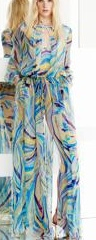

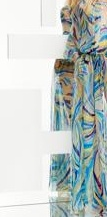

In [0]:
#!find /content/box -size 0 -delete 
img_name= '/content/train/full-body/Abstract_Print_Cutout_Jumpsuitimg_00000039.jpg'
im = cv.imread(img_name)
cv2_imshow(im)  

img_name= '/content/box/train/full-body/Abstract_Print_Cutout_Jumpsuitimg_00000039.jpg'
im = cv.imread(img_name)
cv2_imshow(im)  

#!ls /content/test/full-body #/drive/'My Drive'/data -la


#Вывод

[Colab](https://https://colab.research.google.com/drive/143hGpG7AmJ1bU70K8nLzyqISHID0-q6a)

В ДЗ, использовался датасет DeepFashion [Category and Attribute Prediction Benchmark](https://http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) ,  для распознавания типа одежды ['upper-body', 'lower-body',  'full-body'] , в ДС представлены изображения одежды с описанием атрибутов и точнного положения границ bbox.


Тестируем 3 типа сетей предобученную VGG16, сеть типа VGG, сеть типа ResNet

На вход подавались данные 3 видов, вырезанные bounding box, исходные картинки, bounding box определенные детектором Canny с вырезанным лицом (если найдено), проверяем гипотезу, что точность на данных исходных изображений хуже, чем на данных вырезанных по контурам Canny. 

Сети тренировались на 20 эпохах с одинаковыми гиперепараметрами, 

Получены следующие результаты:

данные (bbox,исходные картинки, canny bbox)

сеть VGG16 (0.900, не тестировалась, 0.722)

сеть типа VGG (0.906, 0.700, 0.650)

сеть типа ResNet (0.876, 0.709, 0.675)

Предобученная сеть VGG16 на данных Canny выдала точность выше, чем на исходных изображениях.  Возможно при доработке алгоритма и подборе параметров, можно достигнуть точности выше чем на исходных изображениях.


In [0]:
import pandas as pd
df = pd.DataFrame({'bbox': ['сеть VGG16', 'сеть типа VGG', 'сеть типа ResNet']})
#df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],axis=1)
# df.iloc[0, 2] = np.nan

#Test

In [0]:
!ls  -la

In [0]:
#!zip -r box.zip box
from google.colab import files
files.download('box.zip')

In [0]:
face_cascade = cv.CascadeClassifier('/content/drive/My Drive/data/haarcascade_frontalface_default.xml')
alt_face_cascade = cv.CascadeClassifier('/content/drive/My Drive/data/haarcascade_frontalface_alt.xml')

def bounding_box(img_name):
  
  def compute_box(bounding_size):    
    min_x, min_y = width, height
    max_x = max_y = 0
    
    # computes the bounding box for the contour, and draws it on the frame,
    for contour, hier in zip(contours, hierarchy):
        (x,y,w,h) = cv.boundingRect(contour)
        if w > bounding_size/3 and h > bounding_size: 
            #cv.rectangle(im, (x,y), (x+w,y+h), (255, 0, 0), 2)
            #min_x, max_x = min(x, min_x), max(x+w, max_x)
            
#             min_x = min(x, min_x)
#             max_x = max_x if w>w/width > .8 else x+w #max(x+w, max_x)
#             min_y, max_y = min(y, min_y), max(y+h, max_y)
            
            min_x, max_x = min(x, min_x), max(x+w, max_x)
            min_y, max_y = min(y, min_y), max(y+h, max_y)

    dx = round(max(0,min(min_x*.2,(width-max_x)*.2)))
    return (min_x-dx, max_x+dx, min_y, max_y)        
#    return (min_x, max_x, min_y, max_y)
    
  
  im = cv.imread(img_name)
#   print(img_name)
#   print(im.shape)
  gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
   
  #cv2_imshow(gray)  

#   thresh = cv.Canny(gray,100,200)
#   im2,contours,hierarchy = cv.findContours(thresh, 1, 2)

  gray = cv.bilateralFilter(gray, 11, 17, 17)
  print(im.shape)
  thresh = cv.Canny(gray, 30, 200)
  im2,contours,hierarchy = cv.findContours(thresh, 1, 2)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  face_y = 0
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces)==0:    
    faces = alt_face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    face_y = y + h   
  
  height, width = im2.shape
  
  min_x, max_x, min_y, max_y = compute_box(15)
  area = (max_x-min_x)*(max_y-min_y)
  part = area/(height*width)
#   if part >.7 : #если область больше 70% исходного изображения, увеличиваем размер минимального контура
#     min_x, max_x, min_y, max_y = compute_box(40)

  
  min_y = max(face_y,min_y)
  if max_x - min_x <= 0 and max_y - min_y <= 0:
    min_x, max_x = 0,width
    min_y, max_y = 0,height
  #print(min_y,max_y, min_x,max_x)
  
  print(max_y-min_y, max_x-min_x)
  return im[min_y:max_y, min_x:max_x]

(300, 300, 3)


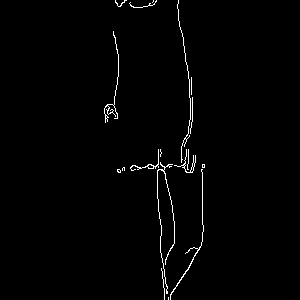

In [0]:
#!ls drive/'My Drive'/data/img
im = cv.imread(fn)
#   print(img_name)
#   print(im.shape)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

#cv2_imshow(gray)  

gray = cv.bilateralFilter(gray, 11, 17, 17)
print(im.shape)
thresh = cv.Canny(gray, 30, im.shape[1])
im2,contours,hierarchy = cv.findContours(thresh, 1, 2)
cv2_imshow(im2)  


(300, 300, 3)
300 138


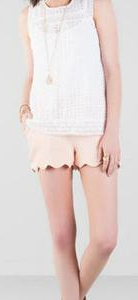

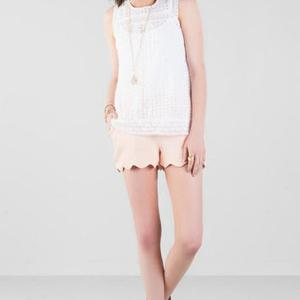

In [0]:
fn = train_X.iloc[12,0]

im = bounding_box(fn)
cv2_imshow(im)  

im = cv.imread(fn)
cv2_imshow(im)

(300, 168, 3)
237 140


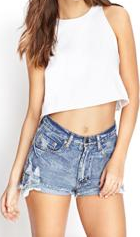

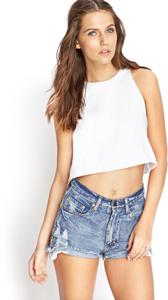

In [0]:
fn = train_X.iloc[24,0]

im = bounding_box(fn)
cv2_imshow(im)  

im = cv.imread(fn)
cv2_imshow(im)

In [0]:
print(np.mean(train_X.x2-train_X.x1))
print(np.mean(train_X.y2-train_X.y1))

103.69280303030303
178.84848484848484


In [0]:
train_X.iloc[1,0]

'/content/drive/My Drive/data/img/Striped_Racerback_Maxi_Dress/img_00000065.jpg'

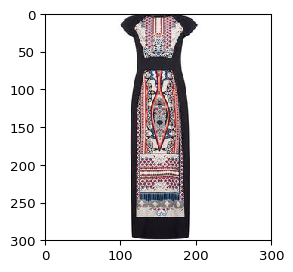

(300, 300, 3)
/content/drive/My Drive/data/img/Tribal_Print_Maxi_Dress/img_00000038.jpg


In [0]:
fn = train_X.iloc[4,0]
#fn = '/content/drive/My Drive/data/img/Striped_Racerback_Maxi_Dress/img_00000065.jpg'
im = ia.imageio.imread(fn)
ia.imshow(im)
print(im.shape)
print(fn)

In [0]:
train_X.iloc[4,:]

image_name       /content/drive/My Drive/data/img/Tribal_Print_...
x1                                                              82
y1                                                               1
x2                                                             225
y2                                                             300
category_type                                                    2
Name: 2887, dtype: object

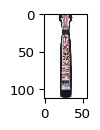

(112, 56, 3)


In [0]:
#!ls box/train/full-body
#fn = 'box/train/upper-body/Tribal_Print_Maxi_Dressimg_00000038.jpg'
fn = 'box/train/full-body/Tribal_Print_Maxi_Dressimg_00000038.jpg'
im = ia.imageio.imread(fn)
ia.imshow(im)
print(im.shape)

In [0]:
round(12.9)

13

In [0]:
def bounding_box(img_name):
  
  def compute_box(bounding_size):    
    min_x, min_y = width, height
    max_x = max_y = 0
    
    # computes the bounding box for the contour, and draws it on the frame,
    for contour, hier in zip(contours, hierarchy):
        (x,y,w,h) = cv.boundingRect(contour)
        if w > bounding_size and h > bounding_size: 
            #cv.rectangle(im, (x,y), (x+w,y+h), (255, 0, 0), 2)
            #min_x, max_x = min(x, min_x), max(x+w, max_x)
            
#             min_x = min(x, min_x)
#             max_x = max_x if w>w/width > .8 else x+w #max(x+w, max_x)
#             min_y, max_y = min(y, min_y), max(y+h, max_y)            
            min_x, max_x = min(x, min_x), max(x+w, max_x)
            min_y, max_y = min(y, min_y), max(y+h, max_y)
    
    #dx = round(max(0,min(min_x*.3,(width-max_x)*.3)))
    return (min_x-dx, max_x+dx, min_y, max_y)
    
  
  im = cv.imread(img_name)
#   print(img_name)
#   print(im.shape)
  gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
   
  #cv2_imshow(gray)  
  gray = cv.bilateralFilter(gray, 11, 17, 17)
  thresh = cv.Canny(gray, 30, 200)
  im2,contours,hierarchy = cv.findContours(thresh, 1, 2)
  
  #thresh = cv.Canny(gray,100,200)
  #thresh = cv.inRange(gray, 100,200 )    
#   ret,thresh = cv.threshold(im,127,255,0)  
#   im2,contours,hierarchy = cv.findContours(thresh,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  face_y = 0
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces)==0:    
    faces = alt_face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    face_y = y + h   
  
  height, width = im2.shape
  
  min_x, max_x, min_y, max_y = compute_box(15)
  area = (max_x-min_x)*(max_y-min_y)
  part = area/(height*width)
  if part >.7 : #если область больше 70% исходного изображения, увеличиваем размер минимального контура
    min_x, max_x, min_y, max_y = compute_box(40)

  
  min_y = max(face_y,min_y)
  if max_x - min_x <= 0 and max_y - min_y <= 0:
    min_x, max_x = 0,width
    min_y, max_y = 0,height
  print(min_y,max_y, min_x,max_x)
  
  return im[min_y:max_y, min_x:max_x]


In [0]:
!ls /content/drive/'My Drive'/data/img/Classic_Double-Breasted_Trench_Coat

img_00000001.jpg  img_00000019.jpg  img_00000037.jpg  img_00000055.jpg
img_00000002.jpg  img_00000020.jpg  img_00000038.jpg  img_00000056.jpg
img_00000003.jpg  img_00000021.jpg  img_00000039.jpg  img_00000057.jpg
img_00000004.jpg  img_00000022.jpg  img_00000040.jpg  img_00000058.jpg
img_00000005.jpg  img_00000023.jpg  img_00000041.jpg  img_00000059.jpg
img_00000006.jpg  img_00000024.jpg  img_00000042.jpg  img_00000060.jpg
img_00000007.jpg  img_00000025.jpg  img_00000043.jpg  img_00000061.jpg
img_00000008.jpg  img_00000026.jpg  img_00000044.jpg  img_00000062.jpg
img_00000009.jpg  img_00000027.jpg  img_00000045.jpg  img_00000063.jpg
img_00000010.jpg  img_00000028.jpg  img_00000046.jpg  img_00000064.jpg
img_00000011.jpg  img_00000029.jpg  img_00000047.jpg  img_00000065.jpg
img_00000012.jpg  img_00000030.jpg  img_00000048.jpg  img_00000066.jpg
img_00000013.jpg  img_00000031.jpg  img_00000049.jpg  img_00000067.jpg
img_00000014.jpg  img_00000032.jpg  img_00000050.jpg  img_00000068.jpg
img_00

74 300 30 201


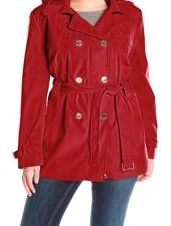

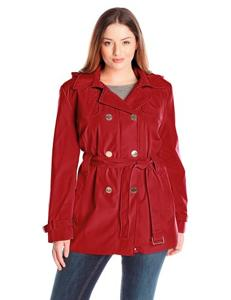

In [0]:
fn = train_X.iloc[17,0]
fn = '/content/drive/My Drive/data/img/Classic_Double-Breasted_Trench_Coat/img_00000050.jpg'
im = bounding_box(fn)
cv2_imshow(im)  

im = cv.imread(fn)
cv2_imshow(im)
#!ls /content/drive/'My Drive'/data/img/Abstract_Print_Maxi_Dress
#74 300 43 188


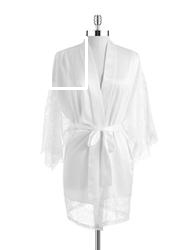

In [0]:
im = cv.imread(fn,0)

thresh = cv.Canny(im,100,200)
#ret,thresh = cv.threshold(im,127,255,0)
im2,contours,hierarchy = cv.findContours(thresh, 1, 2)

try: hierarchy = hierarchy[0]
except: hierarchy = []

height, width = im2.shape
min_x, min_y = width, height
max_x = max_y = 0

# computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv.boundingRect(contour)
#     min_x, max_x = min(x, min_x), max(x+w, max_x)
#     min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 15 and h > 15:
        cv.rectangle(im, (x,y), (x+w,y+h), (255, 0, 0), 2)
        min_x, max_x = min(x, min_x), max(x+w, max_x)
        min_y, max_y = min(y, min_y), max(y+h, max_y)
      

if max_x - min_x > 0 and max_y - min_y > 0:
    cv.rectangle(im, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

#cv.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
cv2_imshow(im)

In [0]:
fn = train_X.iloc[0,0]
fn

'/content/drive/My Drive/data/img/Diamond_Cutout_Sheath_Dress/img_00000009.jpg'

In [0]:
!ls /content/drive/'My Drive'/data/img/Diamond_Cutout_Sheath_Dress

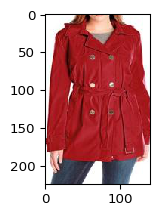

In [0]:
fn = train_X.iloc[12,0]
fn = '/content/drive/My Drive/data/img/Classic_Double-Breasted_Trench_Coat/img_00000050.jpg'
import imageio
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(42)

im = imageio.imread(fn)
#im = ia.imresize_single_image(image, (298, 447))

bbs = BoundingBoxesOnImage([
#    BoundingBox(x1=0, x2=im.shape[0], y1=0, y2=im.shape[1]),
     BoundingBox(x1=0.2*im.shape[1], x2=0.8*im.shape[1], y1=0.2*im.shape[0], y2=0.95*im.shape[0]),
     #BoundingBox(x1=0.4*im.shape[1], x2=0.65*im.shape[1], y1=0.1*im.shape[0], y2=0.4*im.shape[0])
], shape=im.shape)

bbs.on(im)

bb = bbs.bounding_boxes[0].extract_from_image(im)
ia.imshow(bb)

#ia.imshow(bbs.draw_on_image(im, size=2))
# print(bbs.bounding_boxes)
# bb = bbs.bounding_boxes[0].clip_out_of_image(im.shape)
# ia.imshow(bb.draw_on_image(im, thickness=2))

In [0]:
im = imageio.imread(fn)
im.shape

(300, 201, 3)

In [0]:
bbs_aug  =  seq ( image = image ,  bounding_boxes = bbs )

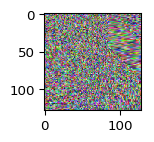

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/local/lib/python3.6/dist-packages/imgaug/multicore.py", line 307, in _Pool_starworker
    return _Pool_worker(*inputs)
  File "/usr/local/lib/python3.6/dist-packages/imgaug/multicore.py", line 300, in _Pool_worker
    result = aug.augment_batch(batch)
  File "/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/meta.py", line 439, in augment_batch
    attr, hooks=hooks)
  File "/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/meta.py", line 603, in augment_images
    hooks=hooks
  

KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/geometric.py", line 1777, in _augment_images
    transformer = self._get_transformer(h, w, nb_rows_samples[i], nb_cols_samples[i], rs_image)
  File "/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/geometric.py", line 1978, in _get_transformer
    matrix.estimate(points_src[:, ::-1], points_dest[:, ::-1])
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py", line 865, in estimate
    affine.estimate(dst[tri, :], src[tri, :])
  File "/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py", line 687, in estimate
    H = np.linalg.inv(dst_matrix) @ H @ src_matrix
  File "/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
KeyboardInterrupt


In [0]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


# Basic augmentation sequence. PiecewiseAffine is slow and therefore well suited
# for augmentation on multiple CPU cores.
aug = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.PiecewiseAffine((0.0, 0.1))
])

# generator that yields images
def create_image_generator(nb_batches, size):
    for _ in range(nb_batches):
        # Add e.g. keypoints=... or bounding_boxes=... here to also augment
        # keypoints / bounding boxes on these images.
        yield ia.Batch(
            images=np.random.randint(0, 255, size=size).astype(np.uint8)
        )

# 500 batches of images, each containing 10 images of size 128x128x3
my_generator = create_image_generator(500, (10, 128, 128, 3))

# Start a pool to augment on multiple CPU cores.
#   * processes=-1 means that all CPU cores except one are used for the
#     augmentation, so one is kept free to move data to the GPU
#   * maxtasksperchild=20 restarts child workers every 20 tasks -- only use this
#     if you encounter problems such as memory leaks. Restarting child workers
#     decreases performance.
#   * seed=123 makes the result of the whole augmentation process deterministic
#     between runs of this script, i.e. reproducible results.
with aug.pool(processes=-1, maxtasksperchild=20, seed=123) as pool:
    # Augment on multiple CPU cores.
    #   * The result of imap_batches() is also a generator.
    #   * Use map_batches() if your input is a list.
    #   * chunksize=10 controls how much data to send to each child worker per
    #     transfer, set it higher for better performance.
    batches_aug_generator = pool.imap_batches(my_generator, chunksize=10)

    for i, batch_aug in enumerate(batches_aug_generator):
        # show first augmented image in first batch
        if i == 0:
            ia.imshow(batch_aug.images_aug[0])
        # do something else with the batch here